# Dynamic Portfolio Optimization with the Autoregressive Integrated Moving Average (ARIMA) Model

## Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas.tseries.offsets import BDay

# Alpha Vantage API for Data
from dotenv import load_dotenv
import os
from alpha_vantage.timeseries import TimeSeries
import time

# Augmented Dickey-Fuller Stationality Test
from statsmodels.tsa.stattools import adfuller

# ARIMA Model 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.stats.diagnostic import acorr_ljungbox

## Retrieve and Examine Data

In [2]:
load_dotenv()

key = os.getenv("ALPHA_VANTAGE_API_KEY")

In [3]:
ts = TimeSeries(key, output_format="pandas")

In [4]:
def fetch_stock_data(symbol):
    data, metadata = ts.get_daily(symbol=symbol, outputsize="full")
    data = data.rename(columns={
        "1. open": "Open",
        "2. high": "High",
        "3. low": "Low",
        "4. close": "Close",
        "5. volume": "Volume"
    })

    data["Close"].plot()
    plt.title(f'Closing Prices for {symbol} Over Time')
    plt.xlabel("Time")
    plt.ylabel("Closing Price (USD)")
    plt.show()
    
    return data

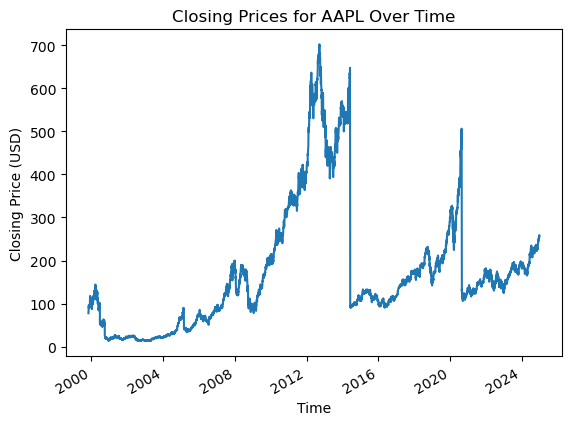

              Open    High     Low   Close       Volume
date                                                   
2024-12-27  257.83  258.70  253.06  255.59   42355321.0
2024-12-26  258.19  260.10  257.63  259.02   27262983.0
2024-12-24  255.49  258.21  255.29  258.20   23234705.0
2024-12-23  254.77  255.65  253.45  255.27   40858774.0
2024-12-20  248.04  255.00  245.69  254.49  147495267.0
              Open         High          Low        Close        Volume
count  6330.000000  6330.000000  6330.000000  6330.000000  6.330000e+03
mean    174.691530   176.621247   172.670805   174.708028  3.322484e+07
std     146.676344   147.884425   145.273650   146.615994  3.052814e+07
min      12.990000    13.190000    12.720000    13.120000  7.025000e+05
25%      79.891250    81.450000    78.542500    80.290000  1.219805e+07
50%     139.950000   141.900000   138.285000   140.010000  2.481560e+07
75%     205.207500   207.220000   203.160000   205.627500  4.442215e+07
max     702.410000   705.070000 

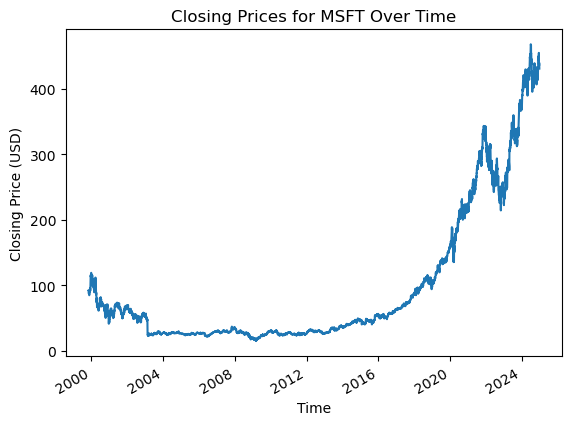

              Open    High     Low   Close      Volume
date                                                  
2024-12-27  434.60  435.22  426.35  430.53  18117713.0
2024-12-26  439.08  440.94  436.63  438.11   8199927.0
2024-12-24  434.65  439.60  434.19  439.33   7164543.0
2024-12-23  436.74  437.65  432.83  435.25  19152519.0
2024-12-20  433.11  443.74  428.63  436.60  64263694.0
              Open         High          Low        Close        Volume
count  6330.000000  6330.000000  6330.000000  6330.000000  6.330000e+03
mean     96.552802    97.551449    95.532856    96.573747  4.500179e+07
std     107.783616   108.744980   106.746597   107.801219  2.731878e+07
min      15.200000    15.620000    14.870000    15.150000  5.850800e+06
25%      27.750000    28.000000    27.512500    27.753250  2.617832e+07
50%      47.105000    47.695000    46.595000    47.175000  3.846920e+07
75%     107.180000   108.472500   105.772500   107.120000  5.650345e+07
max     467.000000   468.350000   464.4

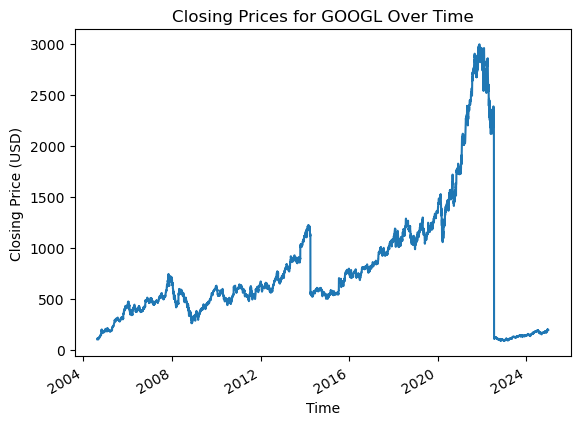

              Open     High      Low   Close      Volume
date                                                    
2024-12-27  194.95  195.320  190.650  192.76  18891362.0
2024-12-26  195.15  196.748  194.375  195.60  12057210.0
2024-12-24  194.84  196.110  193.780  196.11  10403259.0
2024-12-23  192.62  195.100  190.150  194.63  25675014.0
2024-12-20  185.78  192.890  185.220  191.41  63462934.0
              Open         High          Low        Close        Volume
count  5125.000000  5125.000000  5125.000000  5125.000000  5.125000e+03
mean    776.484299   784.216907   768.356911   776.426503  9.226537e+06
std     613.270873   619.404881   606.721558   613.193521  1.138921e+07
min      85.400000    86.520000    83.340000    83.430000  3.845900e+04
25%     415.600000   419.440000   409.470000   415.000000  1.791761e+06
50%     590.390000   594.200000   585.000000   589.870000  4.412100e+06
75%    1016.520000  1032.850000  1006.500000  1018.680000  1.223390e+07
max    3025.000000  3030.

In [5]:
# examine tech sector stocks
symbols = ["AAPL", "MSFT", "GOOGL"]

stock_data = {}

for symbol in symbols:
    stock_data[symbol] = fetch_stock_data(symbol)
    print(stock_data[symbol].head())
    print(stock_data[symbol].describe())
    time.sleep(12)

In [6]:
# isolate closing price data
close_prices = pd.DataFrame({symbol: data["Close"] for symbol, data in stock_data.items()})

close_prices.index = pd.to_datetime(close_prices.index)
close_prices = close_prices.asfreq('B')
close_prices = close_prices.bfill() # fill in missing data instead of dropping to maintain frequency

print(close_prices.index)
print(close_prices.head())
print(close_prices.describe())

DatetimeIndex(['1999-11-01', '1999-11-02', '1999-11-03', '1999-11-04',
               '1999-11-05', '1999-11-08', '1999-11-09', '1999-11-10',
               '1999-11-11', '1999-11-12',
               ...
               '2024-12-16', '2024-12-17', '2024-12-18', '2024-12-19',
               '2024-12-20', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27'],
              dtype='datetime64[ns]', name='date', length=6565, freq='B')
             AAPL   MSFT    GOOGL
date                             
1999-11-01  77.62  92.37  100.335
1999-11-02  80.25  92.56  100.335
1999-11-03  81.50  92.00  100.335
1999-11-04  83.62  91.75  100.335
1999-11-05  88.31  91.56  100.335
              AAPL         MSFT        GOOGL
count  6565.000000  6565.000000  6565.000000
mean    174.717891    96.592500   647.549857
std     146.776504   107.834856   612.060378
min      13.120000    15.150000    83.430000
25%      80.250000    27.760000   136.500000
50%     139.880000    47.190


Augmented Dickey-Fuller Test for AAPL
ADF Statistic for AAPL: -2.566395954301596
p-value for AAPL: 0.1001433177203776
Time series for AAPL is not stationary. Differencing required.


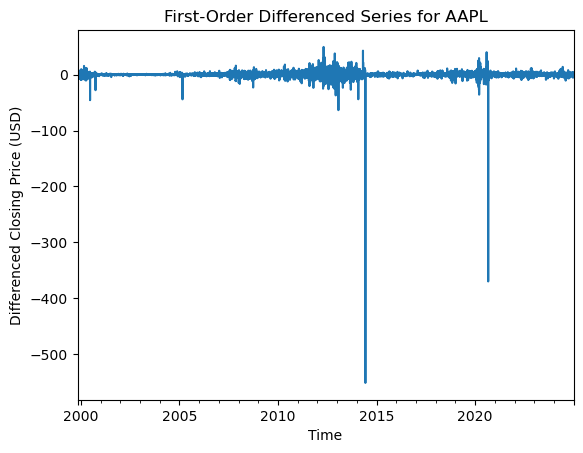


Augmented Dickey-Fuller Test on Differenced Series for AAPL
ADF Statistic: -81.46096662839415
p-value: 0.0
Differenced time series for AAPL is stationary.

Augmented Dickey-Fuller Test for MSFT
ADF Statistic for MSFT: 2.821233470805529
p-value for MSFT: 1.0
Time series for MSFT is not stationary. Differencing required.


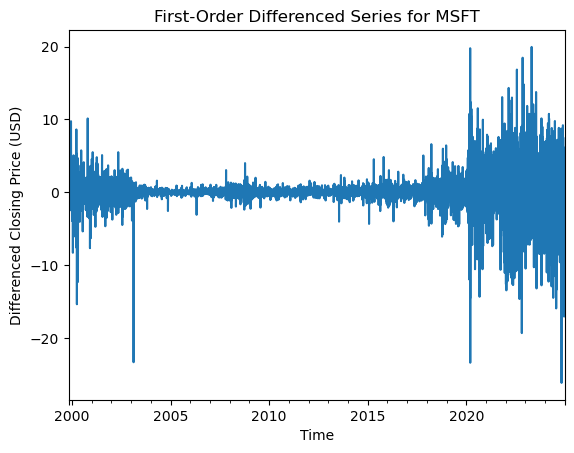


Augmented Dickey-Fuller Test on Differenced Series for MSFT
ADF Statistic: -15.623467928811664
p-value: 1.7203647808544776e-28
Differenced time series for MSFT is stationary.

Augmented Dickey-Fuller Test for GOOGL
ADF Statistic for GOOGL: -2.1131585828882273
p-value for GOOGL: 0.2392564940368927
Time series for GOOGL is not stationary. Differencing required.


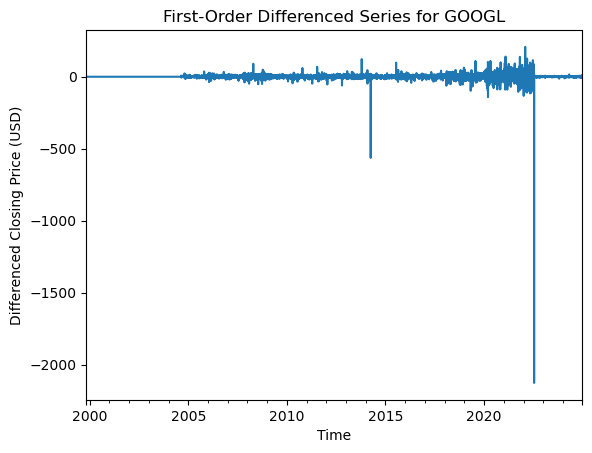


Augmented Dickey-Fuller Test on Differenced Series for GOOGL
ADF Statistic: -15.552838668217698
p-value: 2.089409209395255e-28
Differenced time series for GOOGL is stationary.


In [7]:
# stationality test on the data with Augmented Dickey-Fuller (for ARIMA model)
for symbol in close_prices.columns:
    print(f"\nAugmented Dickey-Fuller Test for {symbol}")
    adf_test_result = adfuller(close_prices[symbol])
    print(f"ADF Statistic for {symbol}: {adf_test_result[0]}")
    print(f"p-value for {symbol}: {adf_test_result[1]}")

    if adf_test_result[1] > 0.05:
        print(f"Time series for {symbol} is not stationary. Differencing required.")
        
        diff_series = close_prices[symbol].diff().dropna()
        diff_series.plot()
        plt.title(f"First-Order Differenced Series for {symbol}")
        plt.xlabel("Time")
        plt.ylabel("Differenced Closing Price (USD)")
        plt.show()

        print(f"\nAugmented Dickey-Fuller Test on Differenced Series for {symbol}")
        adf_diff_result = adfuller(diff_series)
        print(f"ADF Statistic: {adf_diff_result[0]}")
        print(f"p-value: {adf_diff_result[1]}")

        if adf_diff_result[1] > 0.05:
            print(f"Differenced time series for {symbol} is still not stationary.")
        else:
            print(f"Differenced time series for {symbol} is stationary.")
    else:
        print(f"Time series for {symbol} is stationary.")

## Determine Parameters for the ARIMA Model


ACF and PACF plots for Differenced Series of AAPL


<Figure size 1000x600 with 0 Axes>

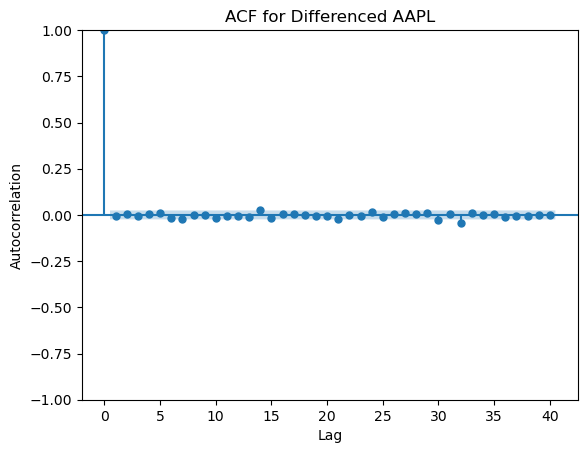

<Figure size 1000x600 with 0 Axes>

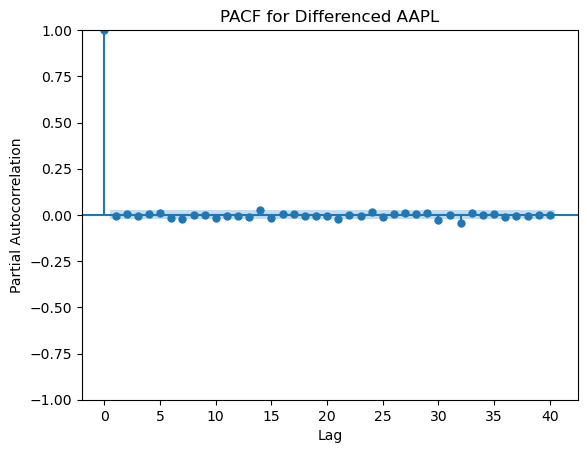


Finding optimal ARIMA model for AAPL
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=47840.939, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=47833.472, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=47835.260, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=47835.263, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=47831.528, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=47837.262, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.613 seconds
Optimal ARIMA order for AAPL: (0, 1, 0)

ARIMA(0,1,0) model summary for AAPL:
                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 6565
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -23914.764
Date:                Sun, 29 Dec 2024   AIC                          47831.528
Time:                        20:09:57   BIC   

<Figure size 1000x600 with 0 Axes>

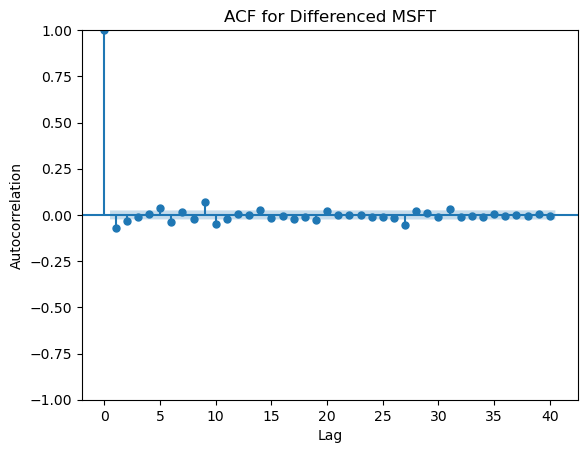

<Figure size 1000x600 with 0 Axes>

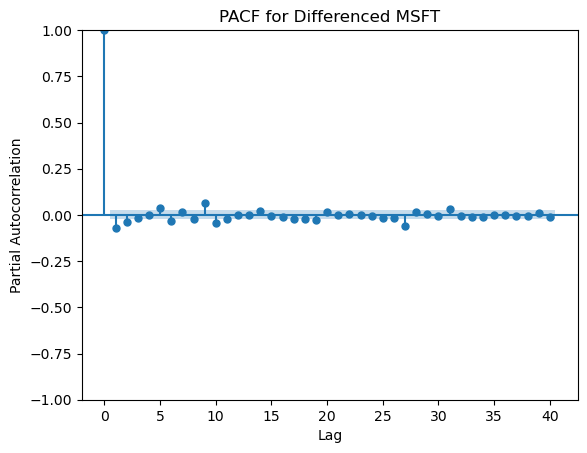


Finding optimal ARIMA model for MSFT
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=34977.058, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=32921.109, Time=0.15 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=34975.059, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=32030.668, Time=0.20 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=31523.568, Time=0.28 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=31127.560, Time=0.37 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=31000.564, Time=0.44 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.15 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.85 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=30998.565, Time=0.26 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=31125.561, Time=0.22 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=1.25 sec
 ARIMA(4,2,

<Figure size 1000x600 with 0 Axes>

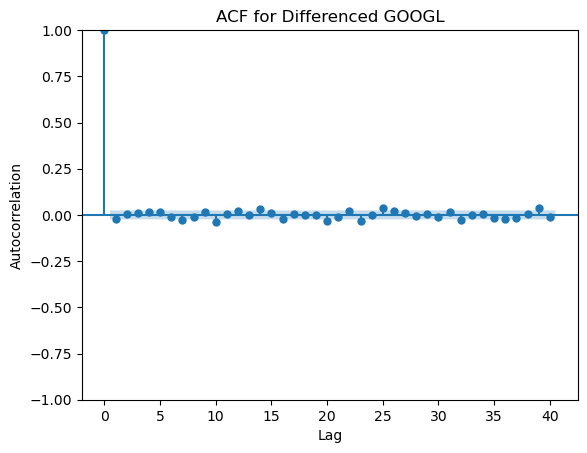

<Figure size 1000x600 with 0 Axes>

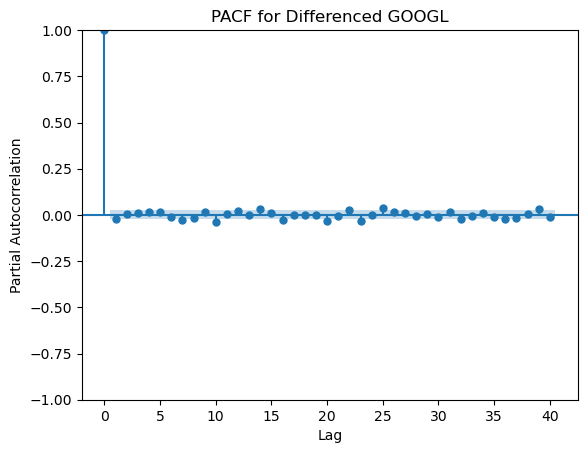


Finding optimal ARIMA model for GOOGL
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=63832.764, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=63831.561, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=63831.599, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63830.765, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=63833.460, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.836 seconds
Optimal ARIMA order for GOOGL: (0, 1, 0)

ARIMA(0,1,0) model summary for GOOGL:
                               SARIMAX Results                                
Dep. Variable:                  GOOGL   No. Observations:                 6565
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -31914.383
Date:                Sun, 29 Dec 2024   AIC                          63830.765
Time:                        20:10:14   BIC      

In [8]:
# optimal ARIMA parameters
arima_models = {}

for symbol in close_prices.columns:
    print(f"\nACF and PACF plots for Differenced Series of {symbol}")
    diff_series = close_prices[symbol].diff().dropna()
    
    plt.figure(figsize=(10, 6))
    plot_acf(diff_series, lags=40)
    plt.title(f"ACF for Differenced {symbol}")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plot_pacf(diff_series, lags=40)
    plt.title(f"PACF for Differenced {symbol}")
    plt.xlabel("Lag")
    plt.ylabel("Partial Autocorrelation")
    plt.show()

    print(f"\nFinding optimal ARIMA model for {symbol}")
    auto_model = auto_arima(
        close_prices[symbol],
        seasonal=False, trace=True,
        error_action="ignore", suppress_warnings=True
    )
    p, d, q = auto_model.order
    print(f"Optimal ARIMA order for {symbol}: ({p}, {d}, {q})")
    
    # fit ARIMA model with optimal parameters
    model = ARIMA(close_prices[symbol], order=(p, d, q))
    fitted_model = model.fit()
    arima_models[symbol] = fitted_model
    
    print(f"\nARIMA({p},{d},{q}) model summary for {symbol}:")
    print(fitted_model.summary())


Residual diagnostics for AAPL


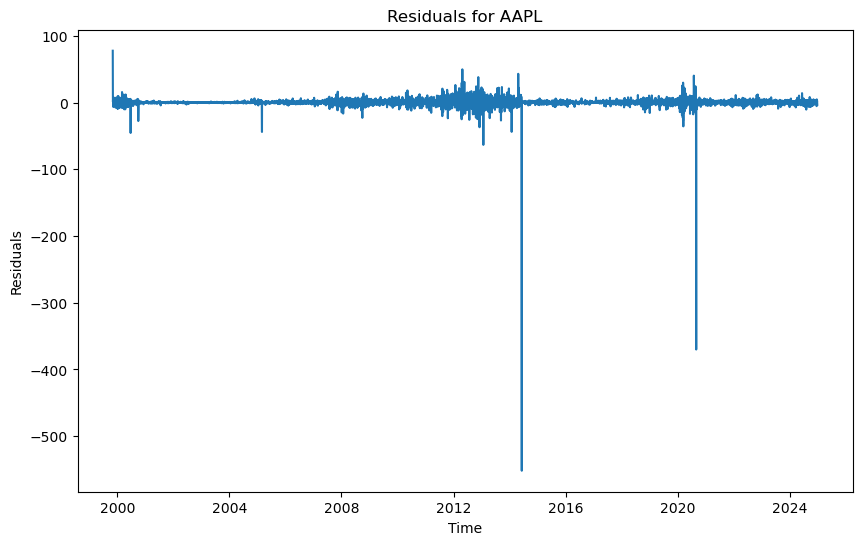

Ljung-Box Test Results for AAPL:
     lb_stat  lb_pvalue
10  7.863938   0.642125

Residual diagnostics for MSFT


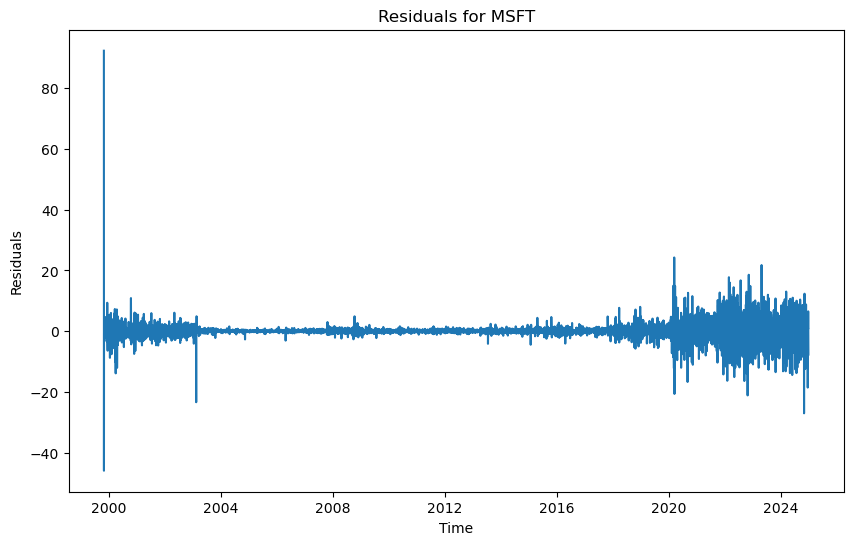

Ljung-Box Test Results for MSFT:
       lb_stat     lb_pvalue
10  325.231411  7.113499e-64

Residual diagnostics for GOOGL


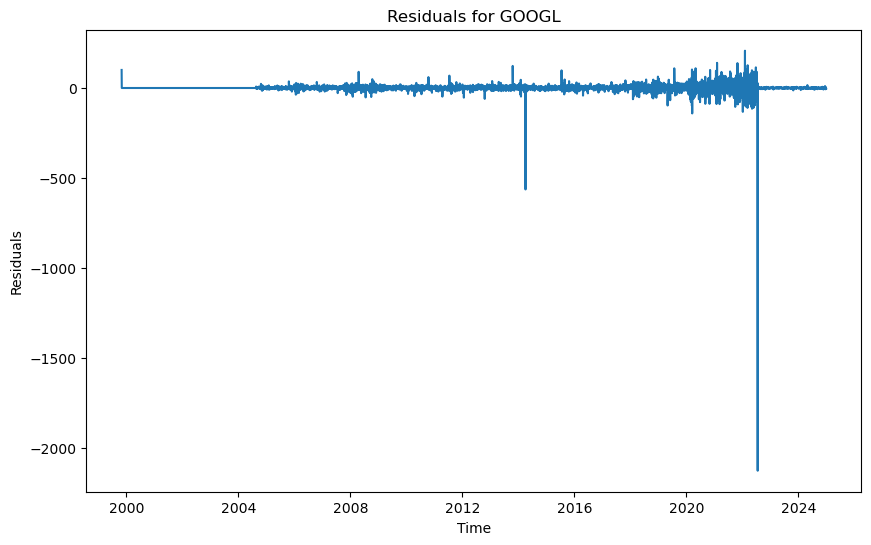

Ljung-Box Test Results for GOOGL:
      lb_stat  lb_pvalue
10  24.128109   0.007268


In [9]:
# validate residuals
for symbol, model in arima_models.items():
    print(f"\nResidual diagnostics for {symbol}")
    residuals = model.resid

    plt.figure(figsize=(10, 6))
    plt.plot(residuals)
    plt.title(f"Residuals for {symbol}")
    plt.xlabel("Time")
    plt.ylabel("Residuals")
    plt.show()

    ljungbox_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print(f"Ljung-Box Test Results for {symbol}:")
    print(ljungbox_test)

## Evaluate Accuracy


Evaluating accuracy for AAPL
(Predicted) Mean Squared Error (MSE) for AAPL: 6.678314285714259
(Predicted) Root Mean Squared Error (RMSE) for AAPL: 2.58424346486825
(Predicted) Mean Absolute Error (MAE) for AAPL: 2.05714285714285


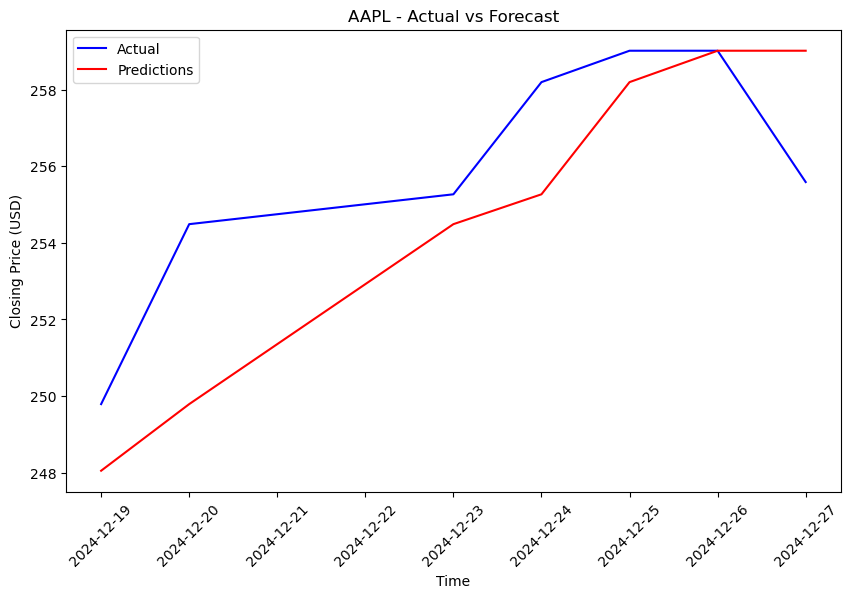


Evaluating accuracy for MSFT
(Predicted) Mean Squared Error (MSE) for MSFT: 16.315825717620754
(Predicted) Root Mean Squared Error (RMSE) for MSFT: 4.039285297873963
(Predicted) Mean Absolute Error (MAE) for MSFT: 3.004378151272379


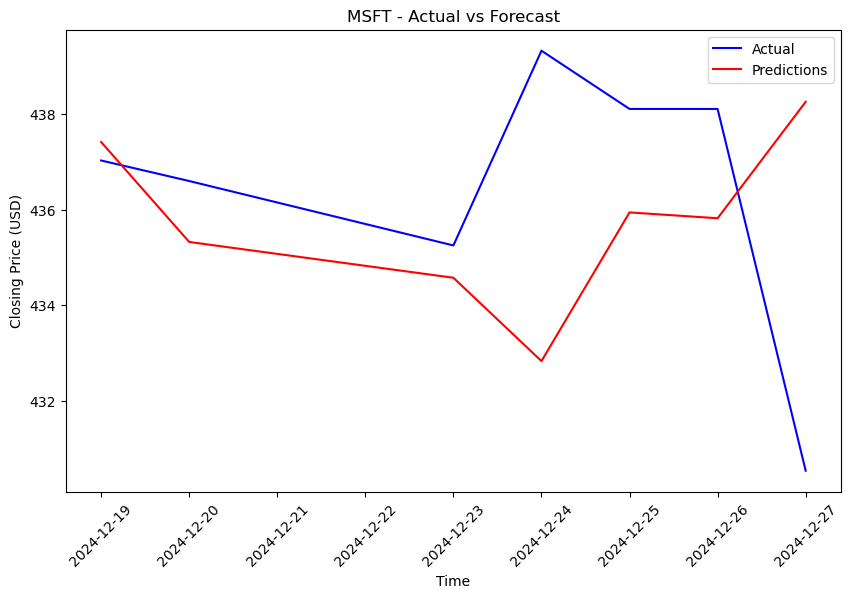


Evaluating accuracy for GOOGL
(Predicted) Mean Squared Error (MSE) for GOOGL: 4.186657142857159
(Predicted) Root Mean Squared Error (RMSE) for GOOGL: 2.0461322398264388
(Predicted) Mean Absolute Error (MAE) for GOOGL: 1.5800000000000043


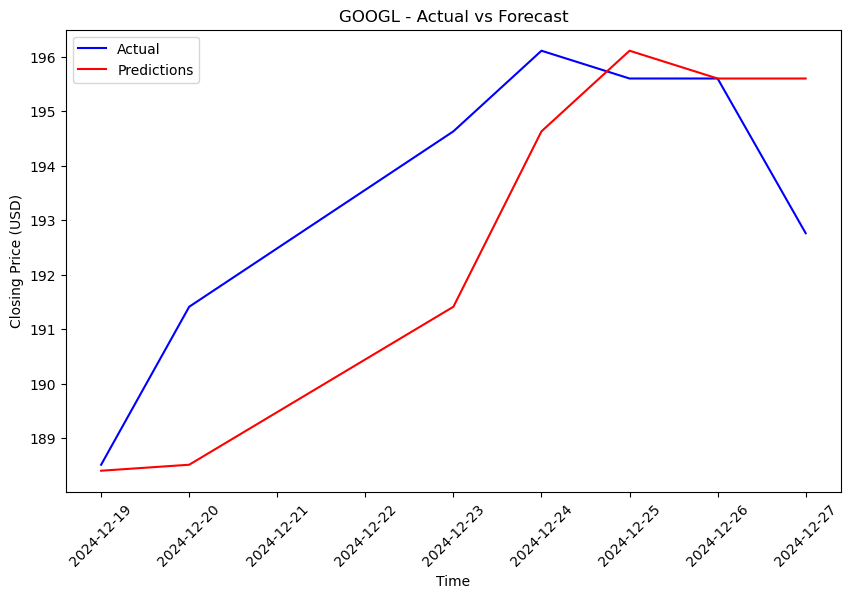

In [10]:
for symbol in close_prices.columns:
    print(f"\nEvaluating accuracy for {symbol}")
    
    # last 7 actual values
    test_data = close_prices[symbol][-7:]
    
    # predict the last 7 values
    predicted = arima_models[symbol].predict(start=len(close_prices[symbol]) - 7, end=len(close_prices[symbol]) - 1)
    
    # calculate errors
    mse_p = mean_squared_error(test_data, predicted)
    rmse_p = np.sqrt(mse_p)
    mae_p = mean_absolute_error(test_data, predicted)

    print(f"(Predicted) Mean Squared Error (MSE) for {symbol}: {mse_p}")
    print(f"(Predicted) Root Mean Squared Error (RMSE) for {symbol}: {rmse_p}")
    print(f"(Predicted) Mean Absolute Error (MAE) for {symbol}: {mae_p}")

    plt.figure(figsize=(10, 6))
    plt.plot(test_data, label="Actual", color="blue")
    plt.plot(predicted, label="Predictions", color="red")
    plt.xticks(rotation=45)
    plt.title(f"{symbol} - Actual vs Forecast")
    plt.xlabel("Time")
    plt.ylabel("Closing Price (USD)")
    plt.legend()
    plt.show()

## Forecast Future Prices


Forecasting future prices for AAPL
Last few actual values:
date
2024-12-23    255.27
2024-12-24    258.20
2024-12-25    259.02
2024-12-26    259.02
2024-12-27    255.59
Freq: B, Name: AAPL, dtype: float64
Forecast values:
2024-12-30    255.59
2024-12-31    255.59
2025-01-01    255.59
2025-01-02    255.59
2025-01-03    255.59
2025-01-06    255.59
2025-01-07    255.59
Freq: B, Name: predicted_mean, dtype: float64


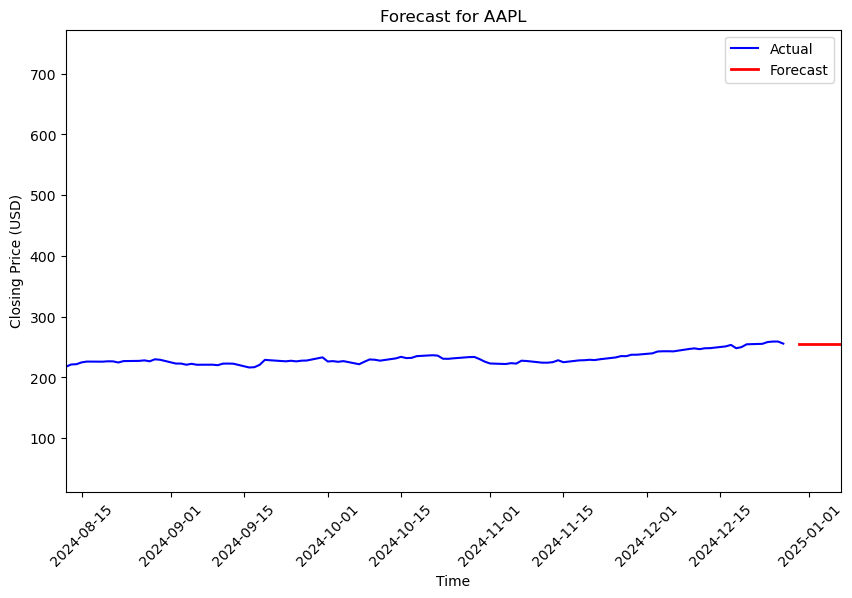


Forecasting future prices for MSFT
Last few actual values:
date
2024-12-23    435.25
2024-12-24    439.33
2024-12-25    438.11
2024-12-26    438.11
2024-12-27    430.53
Freq: B, Name: MSFT, dtype: float64
Forecast values:
2024-12-30    430.012675
2024-12-31    429.278122
2025-01-01    428.023058
2025-01-02    426.009204
2025-01-03    423.679350
2025-01-06    421.588472
2025-01-07    420.165637
Freq: B, Name: predicted_mean, dtype: float64


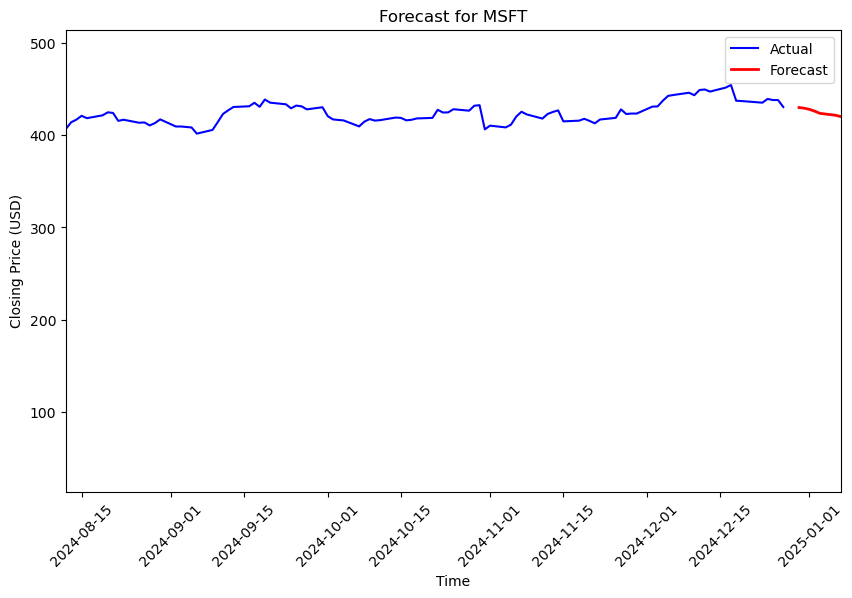


Forecasting future prices for GOOGL
Last few actual values:
date
2024-12-23    194.63
2024-12-24    196.11
2024-12-25    195.60
2024-12-26    195.60
2024-12-27    192.76
Freq: B, Name: GOOGL, dtype: float64
Forecast values:
2024-12-30    192.76
2024-12-31    192.76
2025-01-01    192.76
2025-01-02    192.76
2025-01-03    192.76
2025-01-06    192.76
2025-01-07    192.76
Freq: B, Name: predicted_mean, dtype: float64


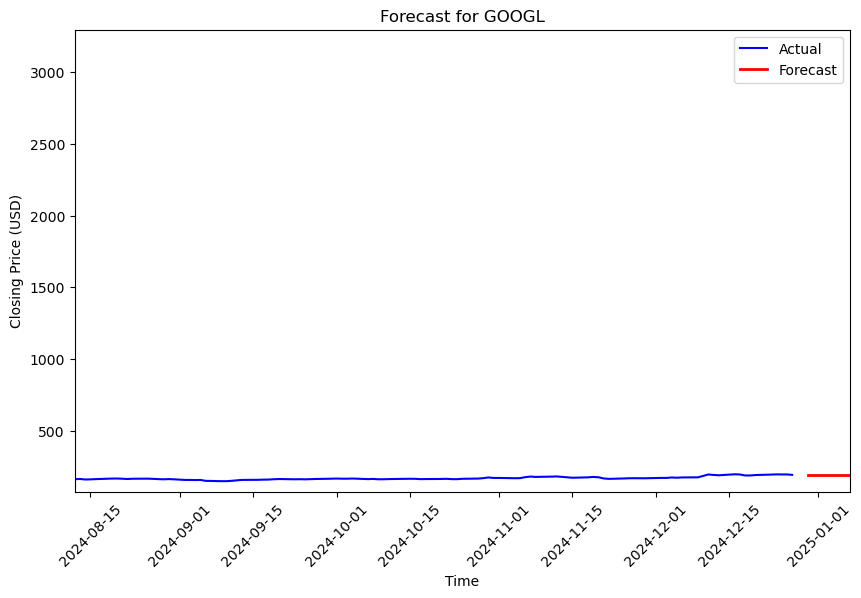

              AAPL        MSFT   GOOGL
2024-12-30  255.59  430.012675  192.76
2024-12-31  255.59  429.278122  192.76
2025-01-01  255.59  428.023058  192.76
2025-01-02  255.59  426.009204  192.76
2025-01-03  255.59  423.679350  192.76
2025-01-06  255.59  421.588472  192.76
2025-01-07  255.59  420.165637  192.76


In [11]:
# forecast 7 days (taking into consideration the accuracy of the ARIMA model)
forecast_horizon = 7 
forecasted_returns = {}

for symbol, model in arima_models.items():
    print(f"\nForecasting future prices for {symbol}")
    
    # forecast future values
    forecast = model.forecast(steps=forecast_horizon)
    forecasted_returns[symbol] = forecast
    
    print("Last few actual values:")
    print(close_prices[symbol].tail())
    
    print("Forecast values:")
    print(forecast)
    
    # new index for forecast
    last_date = close_prices.index[-1]
    forecast_index = [last_date + BDay(i) for i in range(1, forecast_horizon + 1)]
    
    forecast_df = pd.Series(forecast, index=forecast_index)

    plt.figure(figsize=(10, 6))
    plt.plot(close_prices[symbol], label="Actual", color="blue")
    plt.plot(forecast_df, label="Forecast", color="red", linewidth=2)
    
    # zoom-in on plot (last 100 days + forecast)
    plt.ylim([close_prices[symbol].min() * 0.9, close_prices[symbol].max() * 1.1])
    plt.xlim([close_prices.index[-100], forecast_df.index[-1]]) 

    plt.xticks(rotation=45)
    plt.title(f"Forecast for {symbol}")
    plt.xlabel("Time")
    plt.ylabel("Closing Price (USD)")
    plt.legend()
    plt.show()

forecasted_returns_df = pd.DataFrame(forecasted_returns)
print(forecasted_returns_df)